# Logistic Regression


# Model
<h3>prior</h3>

$\theta \sim Normal( \mathbf{m},\Sigma)$ 

<h3>likelihood</h3>

$samples - Bernoulli(\theta^T\mathbf{x})$

In [7]:
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd
import jax
key = jax.random.PRNGKey(0)
import logging
import pickle
import blackjax

logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [9]:
with open("./logistic_regression_data",'rb') as f:
    data = pickle.load(f)

In [23]:
x = data['data']['x']
x[:,:2] = (x[:,:2]- jax.numpy.min(x,axis = 0)[:2])/(jax.numpy.max(x,axis = 0)[:2]-jax.numpy.min(x, axis = 0)[:2])
prior_mean = data['prior']['loc']
prior_var = data['prior']['covariance_matrix']
y = jnp.array(data['data']['y'])
y = jnp.reshape(y, (y.shape[1],))

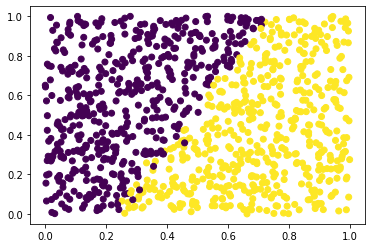

In [24]:
plt.scatter(x[:,0],x[:,1],c=y)

In [25]:

prior_normal = tfd.MultivariateNormalFullCovariance(
    loc= prior_mean,covariance_matrix=prior_var
)
n = 3

In [38]:
m = y.shape[0]
def log_postfn(theta):
    log_prior = prior_normal.log_prob(theta)
    logit = (x@theta.reshape(n,1)).reshape((-1))
    likelihood_bern = tfd.Bernoulli(logit)
    log_like = jnp.sum(likelihood_bern.log_prob(y.reshape(-1)))
    return (log_like+log_prior)
log_postfn(jnp.array([10.4, 11.4,2.4]))



DeviceArray(-5774.5044, dtype=float32)

In [35]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [37]:
rmh = blackjax.rmh(log_postfn, sigma=jnp.identity(n) * 0.8)
initial = jnp.array(jnp.array([12,1.0,12.0]))
initial_state = rmh.init(initial)
initial_state

RMHState(position=DeviceArray([12.,  1., 12.], dtype=float32), log_probability=DeviceArray(-13018.695, dtype=float32))

In [38]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 10000)

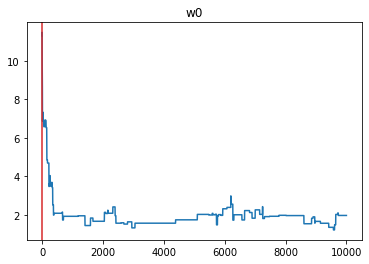

In [39]:
burnin = 0
fig, ax = plt.subplots()
ax.plot(states.position[:,0])
ax.set_title(f"w0")
ax.axvline(x=burnin, c="tab:red")
plt.show()

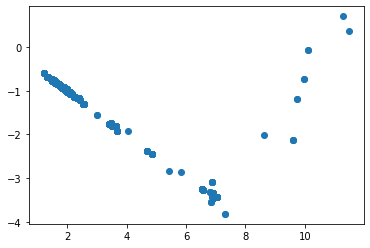

In [40]:
plt.scatter(states.position[burnin:,0],states.position[burnin:,1])

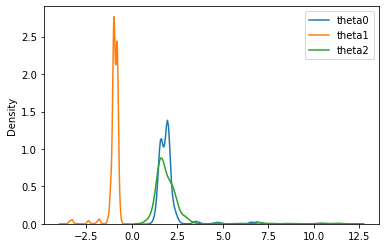

In [42]:
sns.kdeplot(states.position[burnin:,0],label="theta0")
sns.kdeplot(states.position[burnin:,1],label="theta1")
sns.kdeplot(states.position[burnin:,2],label="theta2")
plt.legend()
plt.show()